In [2]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from lsmm_data import LSMMData
import json
from tqdm import tqdm
import scipy.stats as stats

with open('pyr_rect.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

# Generate the chain results

# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
synapse_table = data_a['structural']['synapse']
adjacency_matrix = data_a['structural']['binary_connectome']
pyr_graph = nx.DiGraph()

# Add edges to the graph
rows, cols = data_a['structural']['binary_connectome'].shape
for i in range(rows):
    for j in range(cols):
        if data_a['structural']['binary_connectome'][i, j] != 0:  # 0 means no edge
            pyr_graph.add_edge(f'pre_{i}', f'post_{j}', weight=data_a['structural']['binary_connectome'][i, j])

## Uncomment below to load existing chain motif analysis results
# two_chain_results_array = np.load('all_cell_two_chain_results_array.npy')
# three_chain_results_array = np.load('all_cell_three_chain_results_array.npy')
# four_chain_results_array = np.load('all_cell_four_chain_results_array.npy')

# Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
              """)

chain_results = executor.find(chain_defs)

two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])
removed_pre_post_strings = np.zeros_like(two_chain_results_array)
for i, c in enumerate(chain_results):
    for j, n in enumerate(c.values()):
        removed_pre_post_strings[i, j] = int(n.split('_')[1])

two_chain_results_array = np.array(removed_pre_post_strings).astype(int)

# two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

assembly_chain_results_arrays = [two_chain_results_array]

chain_count_string_array = ['pyr_cell_2chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = [list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))]
pooled_assembly_post_indexes = [list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))]


Generating Connectome...


100%|██████████| 813407/813407 [04:00<00:00, 3387.07it/s]


Generating Connectome...


100%|██████████| 813407/813407 [04:49<00:00, 2811.48it/s]
373158it [00:02, 168521.83it/s]
100%|██████████| 373158/373158 [00:00<00:00, 487062.73it/s]


### Correlation of dff and connection probability


In [3]:
import scipy
import scipy.stats

psds = []
rs = []
for pre_cell in coregistered_cell_indexes:
    pre_functional_index = mappings_a['roi_id_to_functional_index'][mappings_a['pt_root_id_to_roi_id'][mappings_a['connectome_index_to_root_id'][pre_cell]]]
    pre_dff = data_a['functional']['Scan 1-3']['dff'][pre_functional_index]
    for post_cell in coregistered_post_cell_indexes:
        post_functional_index = mappings_a['roi_id_to_functional_index'][mappings_a['pt_root_id_to_roi_id'][mappings_a['post_connectome_index_to_root_id'][post_cell]]]
        post_dff = data_a['functional']['Scan 1-3']['dff'][post_functional_index]
        rs.append(scipy.stats.pearsonr(pre_dff, post_dff)[1])
        psds.append(data_a['structural']['summed_size_connectome'][pre_cell, post_cell])
        
          

## Intra-Assembly vs Intra-No-Assembly: Outbound

Pooled Intra-assembly Connections: 49 out of 1610 possible
No A: 8 out of 396 possible
[6714.0, 1476.0, 4441.0, 1369.0, 2213.0, 3617.0, 357.0, 506.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 394.71875, 0.0, 0.0, 111.9375, 0.0, 113.03125, 0.0, 11.15625, 0.0, 0.0, 15.8125]
[4210.333333333333, 716.4, 602.8333333333334, 51.0, 63.25]
[0.0, 0.09375, 0.0, 0.0, 0.0625, 0.0, 0.03125, 0.0, 0.03125, 0.0, 0.0, 0.03125]
[1.0, 0.4, 0.16666666666666666, 0.14285714285714285, 0.125]
[0.0, 0.09375, 0.09375, 0.09375, 0.15625, 0.15625, 0.1875, 0.1875, 0.21875, 0.21875, 0.21875, 0.25]


SUMMED PSDS

CONNECTION SUMMED PSD: Intra-A vs Intra-No-A
RanksumsResult(statistic=0.04594768006447692, pvalue=0.48167597554340214)

PRE-CELL COMBINED OUTBOUND SUMMED PSD: Intra-A vs Intra-No-A
RanksumsResult(statistic=0.03182139626298652, pvalue=0.48730724176259305)

PRE-CELL COMBINED OUTBOUND SUMMED PSD (NONZERO): Intra-A vs Intra-No-A
RanksumsResult(statistic=0.7108186533109109, pvalue=0.23859830999438503)


SYNAPS

Text(0.5, 1.0, 'PRE-CELL OUTBOUND CONNECTION PROB: Intra-A vs Intra-No-A\np=0.9999970402642385')

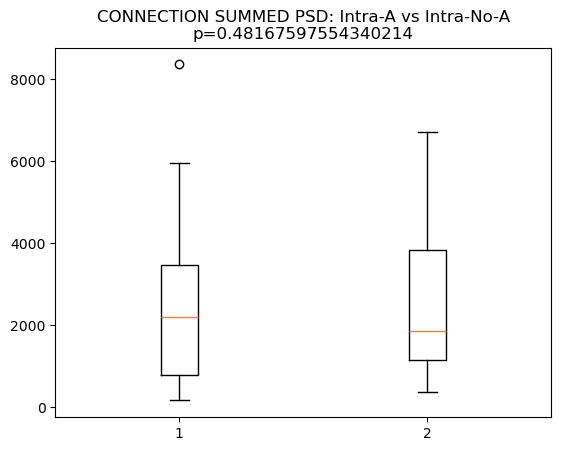

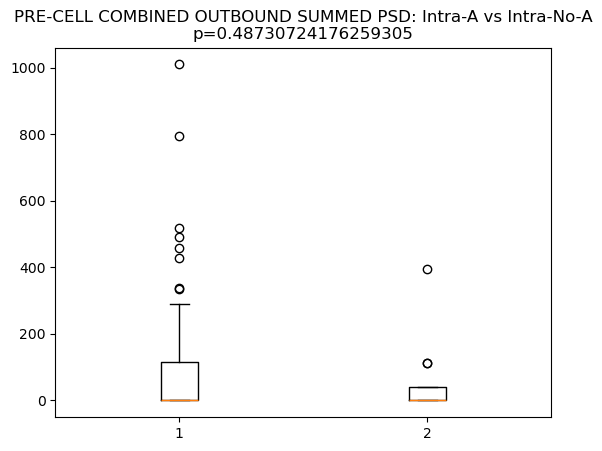

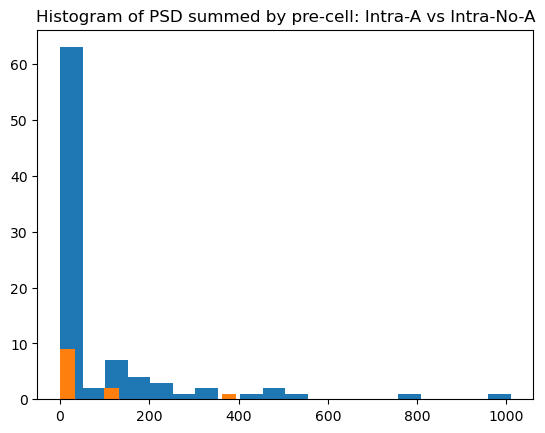

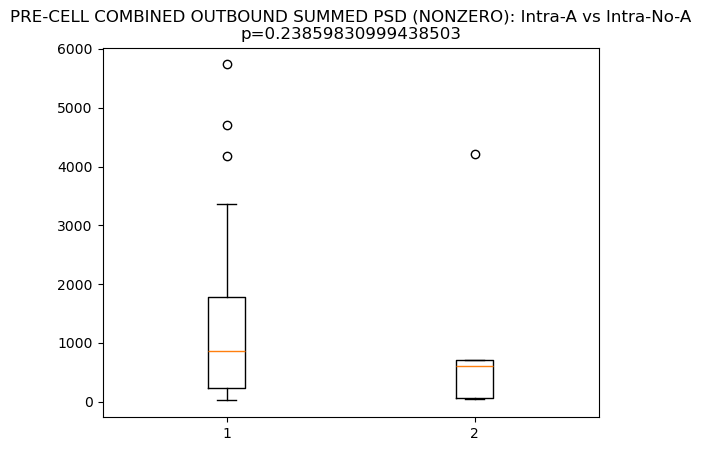

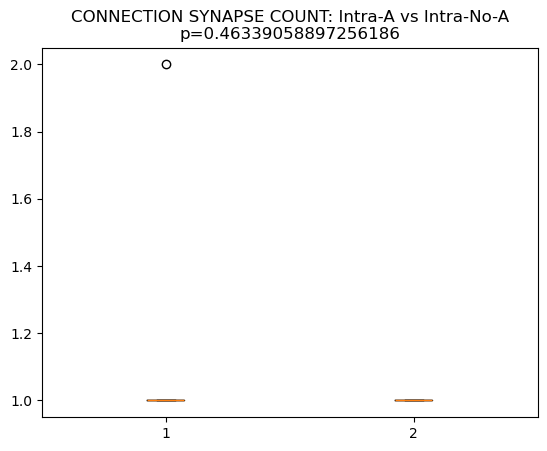

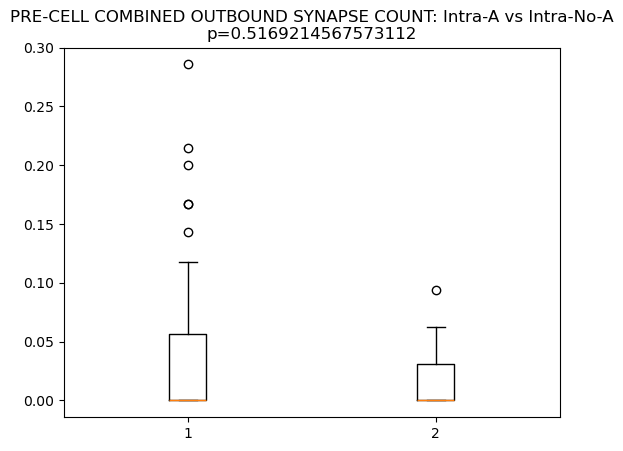

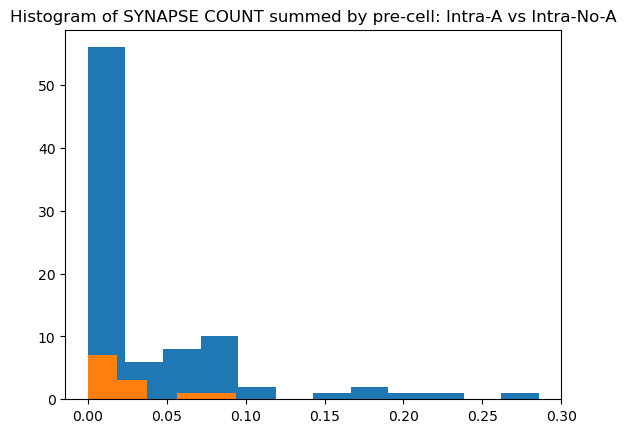

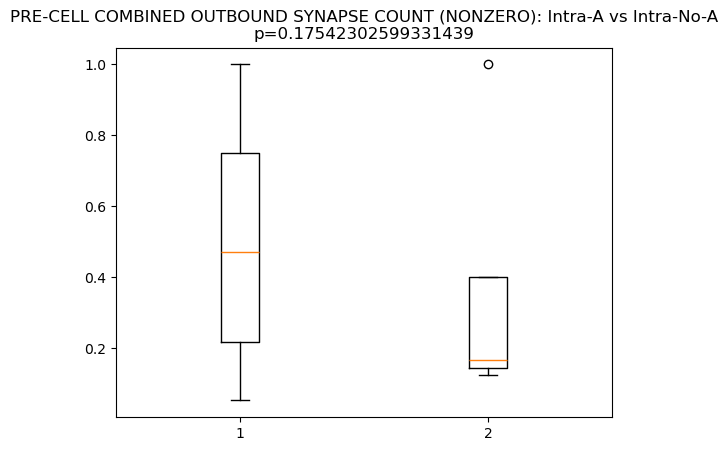

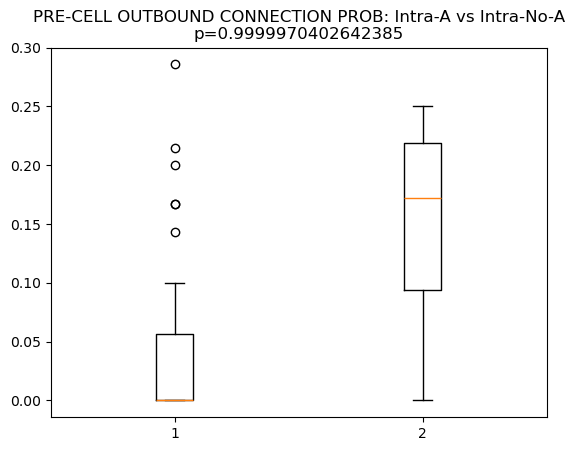

In [4]:
# Breadcrumb: make this into a funciton with group sets passed in?

zero_counts = 0
connections = 0
group_one_connection_summed_psd_sizes = []
group_one_connection_synapse_count = []
summed_group_one_outbound_summed_psd_sizes = []
nonzero_summed_group_one_outbound_summed_psd_sizes = []
summed_group_one_outbound_synapse_counts = []
nonzero_summed_group_one_outbound_synapse_counts = []
summed_group_one_outbound_connection_probability = []
for ai in range(len(individual_assembly_indexes)):
    # This should be n_pre * n_post - 1 if connecting within group.
    # n_pre * n_unique_post if connecting to another group
    per_assembly_connections = 0
    possible_connections_within_group = len(individual_assembly_indexes[ai]) * (len(individual_post_assembly_indexes[ai]) - 1)
    possible_outbound_connections_within_group = (len(individual_post_assembly_indexes[ai]) - 1)
    for pre_cell in individual_assembly_indexes[ai]:
        summed_psd_sizes_sum = 0
        summed_synapse_counts = 0
        per_cell_connections = 0
        for post_cell in individual_post_assembly_indexes[ai]:
            if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                summed_psd_sizes = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                synapse_count = data_a['structural']['synapse_count_connectome'][pre_cell, post_cell]
                group_one_connection_summed_psd_sizes.append(summed_psd_sizes)
                group_one_connection_synapse_count.append(synapse_count)
                summed_psd_sizes_sum += summed_psd_sizes
                summed_synapse_counts += synapse_count
                connections += 1
                per_assembly_connections += 1
                per_cell_connections += 1
            else:
                zero_counts += 1
        if summed_psd_sizes_sum > 0:
            nonzero_summed_group_one_outbound_summed_psd_sizes.append(summed_psd_sizes_sum / per_assembly_connections)
        if summed_synapse_counts > 0:
            nonzero_summed_group_one_outbound_synapse_counts.append(summed_synapse_counts / per_assembly_connections)
        if possible_outbound_connections_within_group > 0:
            summed_group_one_outbound_summed_psd_sizes.append(summed_psd_sizes_sum / possible_outbound_connections_within_group)
            summed_group_one_outbound_synapse_counts.append(summed_synapse_counts / possible_outbound_connections_within_group)
            summed_group_one_outbound_connection_probability.append(per_cell_connections / possible_outbound_connections_within_group)
print(f'Pooled Intra-assembly Connections: {connections} out of {zero_counts + connections} possible')

zero_counts = 0
connections = 0

group_two_connection_summed_psd_sizes = []
group_two_connection_synapse_count = []
summed_group_two_outbound_summed_psd_sizes = []
nonzero_summed_group_two_outbound_summed_psd_sizes = []
summed_group_two_outbound_synapse_counts = []
nonzero_summed_group_two_outbound_synapse_counts = []
summed_group_two_outbound_connection_probability = []

for pre_cell in no_a_cell_indexes:
    if len(no_a_post_cell_indexes) > 1:
        summed_psd_sizes_sum = 0
        summed_synapse_counts = 0
        for post_cell in no_a_post_cell_indexes:
            if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                summed_psd_sizes = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                synapse_count = data_a['structural']['synapse_count_connectome'][pre_cell, post_cell]
                group_two_connection_summed_psd_sizes.append(summed_psd_sizes)
                group_two_connection_synapse_count.append(synapse_count)
                summed_psd_sizes_sum += summed_psd_sizes
                summed_synapse_counts += synapse_count
                connections += 1
            else:
                zero_counts += 1
        if summed_psd_sizes_sum > 0:
            nonzero_summed_group_two_outbound_summed_psd_sizes.append(summed_psd_sizes_sum / connections)
        if summed_synapse_counts > 0:
            nonzero_summed_group_two_outbound_synapse_counts.append(summed_synapse_counts / connections)
        summed_group_two_outbound_summed_psd_sizes.append(summed_psd_sizes_sum / (len(no_a_post_cell_indexes) - 1))
        summed_group_two_outbound_synapse_counts.append(summed_synapse_counts / (len(no_a_post_cell_indexes) - 1))
        summed_group_two_outbound_connection_probability.append(connections / (len(no_a_post_cell_indexes) - 1))
print(f'No A: {connections} out of {zero_counts + connections} possible')

# print(f'{len(coregistered_cell_indexes)} x {len(coregistered_post_cell_indexes)}')

print(group_two_connection_summed_psd_sizes)
print(group_two_connection_synapse_count)
print(summed_group_two_outbound_summed_psd_sizes)
print(nonzero_summed_group_two_outbound_summed_psd_sizes)
print(summed_group_two_outbound_synapse_counts)
print(nonzero_summed_group_two_outbound_synapse_counts)
print(summed_group_two_outbound_connection_probability)

print('\n\nSUMMED PSDS')

print('\nCONNECTION SUMMED PSD: Intra-A vs Intra-No-A')
p_value = stats.ranksums(group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes])
plt.title(f'CONNECTION SUMMED PSD: Intra-A vs Intra-No-A\np={p_value}')

print('\nPRE-CELL COMBINED OUTBOUND SUMMED PSD: Intra-A vs Intra-No-A')
p_value = stats.ranksums(summed_group_one_outbound_summed_psd_sizes, summed_group_two_outbound_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(summed_group_one_outbound_summed_psd_sizes, summed_group_two_outbound_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_outbound_summed_psd_sizes, summed_group_two_outbound_summed_psd_sizes])
plt.title(f'PRE-CELL COMBINED OUTBOUND SUMMED PSD: Intra-A vs Intra-No-A\np={p_value}')
# print("Medians", np.median(summed_group_one_outbound_summed_psd_sizes), np.median(summed_group_two_outbound_summed_psd_sizes))

plt.figure()
plt.hist(summed_group_one_outbound_summed_psd_sizes, bins='auto')
plt.hist(summed_group_two_outbound_summed_psd_sizes, bins='auto')
plt.title('Histogram of PSD summed by pre-cell: Intra-A vs Intra-No-A')

print('\nPRE-CELL COMBINED OUTBOUND SUMMED PSD (NONZERO): Intra-A vs Intra-No-A')
p_value = stats.ranksums(nonzero_summed_group_one_outbound_summed_psd_sizes, nonzero_summed_group_two_outbound_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(nonzero_summed_group_one_outbound_summed_psd_sizes, nonzero_summed_group_two_outbound_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_group_one_outbound_summed_psd_sizes, nonzero_summed_group_two_outbound_summed_psd_sizes])
plt.title(f'PRE-CELL COMBINED OUTBOUND SUMMED PSD (NONZERO): Intra-A vs Intra-No-A\np={p_value}')


print('\n\nSYNAPSE COUNTS')
print('\nCONNECTION SYNAPSE COUNT: Intra-A vs Intra-No-A')
p_value = stats.ranksums(group_one_connection_synapse_count, group_two_connection_synapse_count, alternative='greater')[1]
print(stats.ranksums(group_one_connection_synapse_count, group_two_connection_synapse_count, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_synapse_count, group_two_connection_synapse_count])
plt.title(f'CONNECTION SYNAPSE COUNT: Intra-A vs Intra-No-A\np={p_value}')

print('\nPRE-CELL COMBINED OUTBOUND SYNAPSE COUNT: Intra-A vs Intra-No-A')
p_value = stats.ranksums(summed_group_one_outbound_synapse_counts, summed_group_two_outbound_synapse_counts, alternative='greater')[1]
print(stats.ranksums(summed_group_one_outbound_synapse_counts, summed_group_two_outbound_synapse_counts, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_outbound_synapse_counts, summed_group_two_outbound_synapse_counts])
plt.title(f'PRE-CELL COMBINED OUTBOUND SYNAPSE COUNT: Intra-A vs Intra-No-A\np={p_value}')
# print("Medians", np.median(summed_group_one_outbound_synapse_counts), np.median(summed_group_two_outbound_synapse_counts))

plt.figure()
plt.hist(summed_group_one_outbound_synapse_counts, bins='auto')
plt.hist(summed_group_two_outbound_synapse_counts, bins='auto')
plt.title('Histogram of SYNAPSE COUNT summed by pre-cell: Intra-A vs Intra-No-A')

print('\nPRE-CELL COMBINED OUTBOUND SYNAPSE COUNT (NONZERO): Intra-A vs Intra-No-A')
p_value = stats.ranksums(nonzero_summed_group_one_outbound_synapse_counts, nonzero_summed_group_two_outbound_synapse_counts, alternative='greater')[1]
print(stats.ranksums(nonzero_summed_group_one_outbound_synapse_counts, nonzero_summed_group_two_outbound_synapse_counts, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_group_one_outbound_synapse_counts, nonzero_summed_group_two_outbound_synapse_counts])
plt.title(f'PRE-CELL COMBINED OUTBOUND SYNAPSE COUNT (NONZERO): Intra-A vs Intra-No-A\np={p_value}')

print('\n\nPRE-CELL OUTBOUND CONNECTION PROB')
p_value = stats.ranksums(summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability, alternative='greater')[1]
print(stats.ranksums(summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability])
plt.title(f'PRE-CELL OUTBOUND CONNECTION PROB: Intra-A vs Intra-No-A\np={p_value}')


## Intra-Assembly vs Intra-No-Assembly: Inbound

Pooled Intra-assembly Connections: 49 out of 1610 possible
No A: 8 out of 396 possible
[6714.0, 506.0, 1476.0, 1369.0, 4441.0, 3617.0, 357.0, 2213.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 610.3636363636364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 258.6363636363636, 0.0, 0.0, 403.72727272727275, 0.0, 0.0, 328.8181818181818, 0.0, 0.0, 0.0, 32.45454545454545, 0.0, 0.0, 0.0, 0.0, 0.0, 201.1818181818182]
[6714.0, 253.0, 711.25, 888.2, 602.8333333333334, 51.0, 276.625]
[0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.18181818181818182, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091]
[1.0, 0.5, 0.5, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125]
[0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.0909090909090909

Text(0.5, 1.0, 'PRE-CELL inbound CONNECTION PROB: Intra-A vs Intra-No-A\np=0.9999999999882898')

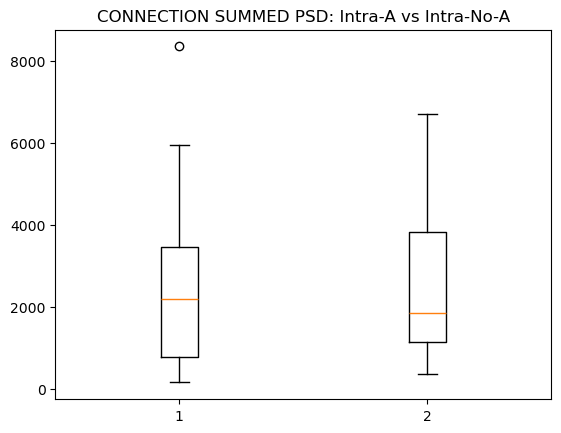

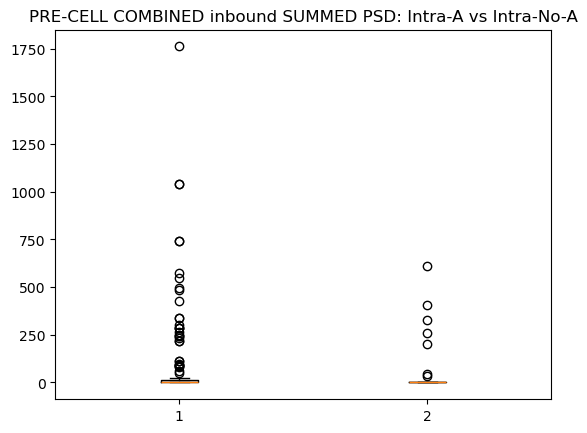

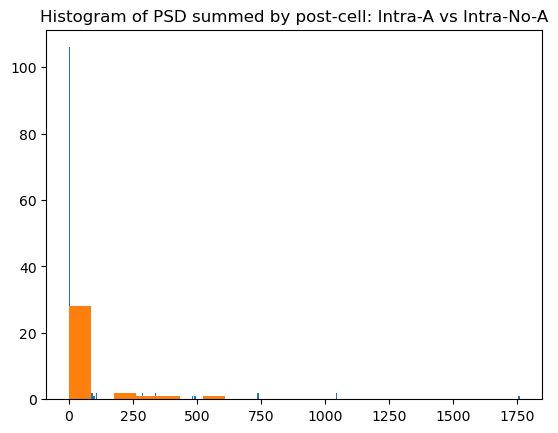

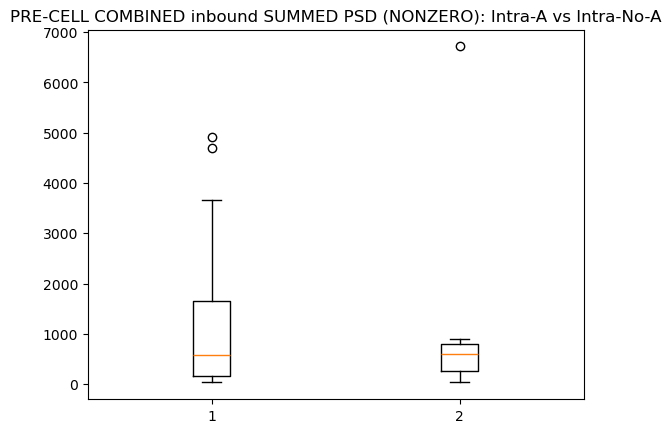

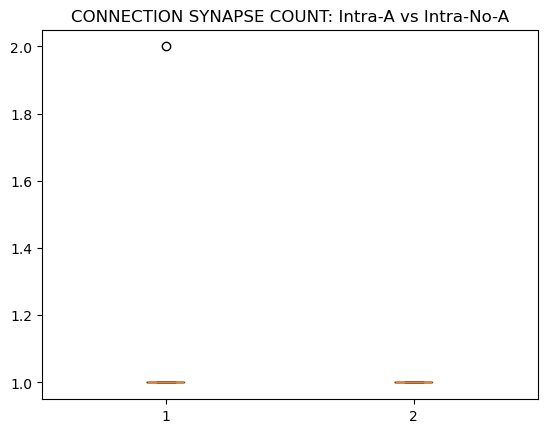

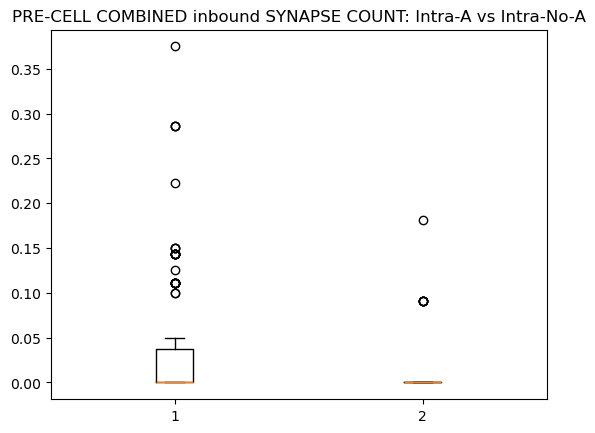

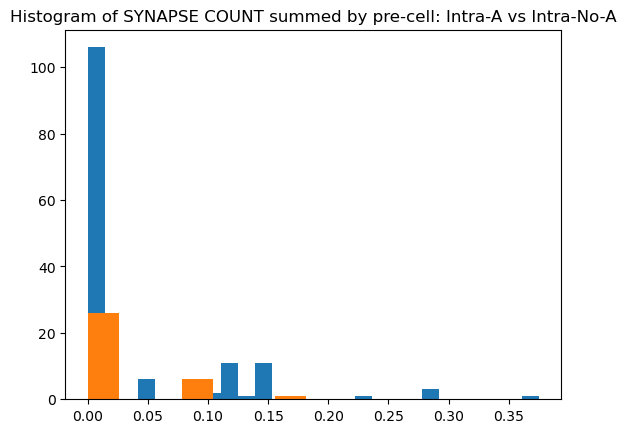

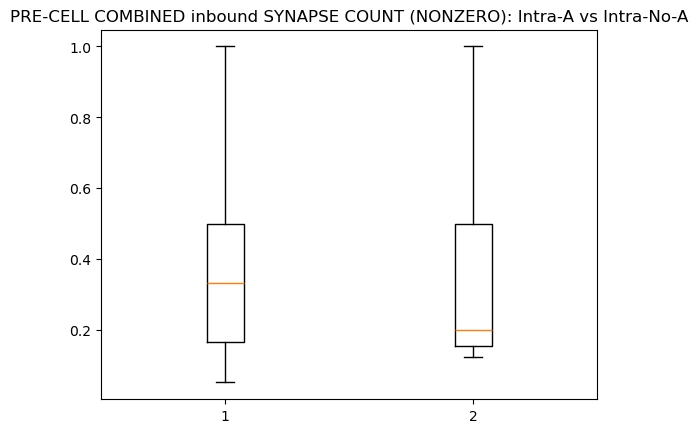

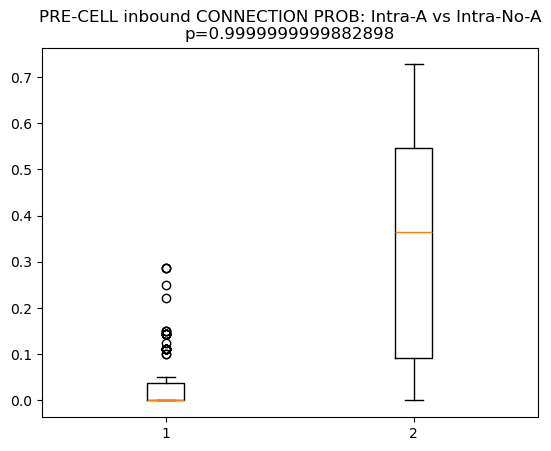

In [5]:
zero_counts = 0
connections = 0
group_one_connection_summed_psd_sizes = []
group_one_connection_synapse_count = []
summed_group_one_inbound_summed_psd_sizes = []
nonzero_summed_group_one_inbound_summed_psd_sizes = []
summed_group_one_inbound_synapse_counts = []
nonzero_summed_group_one_inbound_synapse_counts = []
summed_group_one_inbound_connection_probability = []
for ai in range(len(individual_assembly_indexes)):
    # This should be n_pre * n_post - 1 if connecting within group.
    # n_pre * n_unique_post if connecting to another group
    per_assembly_connections = 0
    possible_connections_within_group = len(individual_post_assembly_indexes[ai]) * (len(individual_assembly_indexes[ai]) - 1)
    possible_inbound_connections_within_group = (len(individual_assembly_indexes[ai]) - 1)
    for post_cell in individual_post_assembly_indexes[ai]:
        summed_psd_sizes_sum = 0
        summed_synapse_counts = 0
        per_cell_connections = 0
        for pre_cell in individual_assembly_indexes[ai]:
            if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                summed_psd_sizes = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                synapse_count = data_a['structural']['synapse_count_connectome'][pre_cell, post_cell]
                group_one_connection_summed_psd_sizes.append(summed_psd_sizes)
                group_one_connection_synapse_count.append(synapse_count)
                summed_psd_sizes_sum += summed_psd_sizes
                summed_synapse_counts += synapse_count
                connections += 1
                per_assembly_connections += 1
                per_cell_connections += 1
            else:
                zero_counts += 1
        if summed_psd_sizes_sum > 0:
            nonzero_summed_group_one_inbound_summed_psd_sizes.append(summed_psd_sizes_sum / per_assembly_connections)
        if summed_synapse_counts > 0:
            nonzero_summed_group_one_inbound_synapse_counts.append(summed_synapse_counts / per_assembly_connections)
        if possible_inbound_connections_within_group > 0:
            summed_group_one_inbound_summed_psd_sizes.append(summed_psd_sizes_sum / possible_inbound_connections_within_group)
            summed_group_one_inbound_synapse_counts.append(summed_synapse_counts / possible_inbound_connections_within_group)
            summed_group_one_inbound_connection_probability.append(per_cell_connections / possible_inbound_connections_within_group)
print(f'Pooled Intra-assembly Connections: {connections} out of {zero_counts + connections} possible')

zero_counts = 0
connections = 0

group_two_connection_summed_psd_sizes = []
group_two_connection_synapse_count = []
summed_group_two_inbound_summed_psd_sizes = []
nonzero_summed_group_two_inbound_summed_psd_sizes = []
summed_group_two_inbound_synapse_counts = []
nonzero_summed_group_two_inbound_synapse_counts = []
summed_group_two_inbound_connection_probability = []

for post_cell in no_a_post_cell_indexes:
    if len(no_a_post_cell_indexes) > 1:
        summed_psd_sizes_sum = 0
        summed_synapse_counts = 0
        for pre_cell in no_a_cell_indexes:
            if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                summed_psd_sizes = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                synapse_count = data_a['structural']['synapse_count_connectome'][pre_cell, post_cell]
                group_two_connection_summed_psd_sizes.append(summed_psd_sizes)
                group_two_connection_synapse_count.append(synapse_count)
                summed_psd_sizes_sum += summed_psd_sizes
                summed_synapse_counts += synapse_count
                connections += 1
            else:
                zero_counts += 1
        if summed_psd_sizes_sum > 0:
            nonzero_summed_group_two_inbound_summed_psd_sizes.append(summed_psd_sizes_sum / connections)
        if summed_synapse_counts > 0:
            nonzero_summed_group_two_inbound_synapse_counts.append(summed_synapse_counts / connections)
        summed_group_two_inbound_summed_psd_sizes.append(summed_psd_sizes_sum / (len(no_a_cell_indexes) - 1))
        summed_group_two_inbound_synapse_counts.append(summed_synapse_counts / (len(no_a_cell_indexes) - 1))
        summed_group_two_inbound_connection_probability.append(connections / (len(no_a_cell_indexes) - 1))
print(f'No A: {connections} out of {zero_counts + connections} possible')

# print(f'{len(coregistered_cell_indexes)} x {len(coregistered_post_cell_indexes)}')

print(group_two_connection_summed_psd_sizes)
print(group_two_connection_synapse_count)
print(summed_group_two_inbound_summed_psd_sizes)
print(nonzero_summed_group_two_inbound_summed_psd_sizes)
print(summed_group_two_inbound_synapse_counts)
print(nonzero_summed_group_two_inbound_synapse_counts)
print(summed_group_two_inbound_connection_probability)

print('\n\nSUMMED PSDS')

print('\nCONNECTION SUMMED PSD: Intra-A vs Intra-No-A')
print(stats.ranksums(group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes])
plt.title(f'CONNECTION SUMMED PSD: Intra-A vs Intra-No-A')

print('\nPRE-CELL COMBINED inbound SUMMED PSD: Intra-A vs Intra-No-A')
print(stats.ranksums(summed_group_one_inbound_summed_psd_sizes, summed_group_two_inbound_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_inbound_summed_psd_sizes, summed_group_two_inbound_summed_psd_sizes])
plt.title(f'PRE-CELL COMBINED inbound SUMMED PSD: Intra-A vs Intra-No-A')
# print("Medians", np.median(summed_group_one_inbound_summed_psd_sizes), np.median(summed_group_two_inbound_summed_psd_sizes))

plt.figure()
plt.hist(summed_group_one_inbound_summed_psd_sizes, bins='auto')
plt.hist(summed_group_two_inbound_summed_psd_sizes, bins='auto')
plt.title('Histogram of PSD summed by post-cell: Intra-A vs Intra-No-A')

print('\nPRE-CELL COMBINED inbound SUMMED PSD (NONZERO): Intra-A vs Intra-No-A')
print(stats.ranksums(nonzero_summed_group_one_inbound_summed_psd_sizes, nonzero_summed_group_two_inbound_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_group_one_inbound_summed_psd_sizes, nonzero_summed_group_two_inbound_summed_psd_sizes])
plt.title(f'PRE-CELL COMBINED inbound SUMMED PSD (NONZERO): Intra-A vs Intra-No-A')

print('\n\nSYNAPSE COUNTS')
print('\nCONNECTION SYNAPSE COUNT: Intra-A vs Intra-No-A')
print(stats.ranksums(group_one_connection_synapse_count, group_two_connection_synapse_count, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_synapse_count, group_two_connection_synapse_count])
plt.title(f'CONNECTION SYNAPSE COUNT: Intra-A vs Intra-No-A')

print('\nPRE-CELL COMBINED inbound SYNAPSE COUNT: Intra-A vs Intra-No-A')
print(stats.ranksums(summed_group_one_inbound_synapse_counts, summed_group_two_inbound_synapse_counts, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_inbound_synapse_counts, summed_group_two_inbound_synapse_counts])
plt.title(f'PRE-CELL COMBINED inbound SYNAPSE COUNT: Intra-A vs Intra-No-A')
# print("Medians", np.median(summed_group_one_inbound_synapse_counts), np.median(summed_group_two_inbound_synapse_counts))

plt.figure()
plt.hist(summed_group_one_inbound_synapse_counts, bins='auto')
plt.hist(summed_group_two_inbound_synapse_counts, bins='auto')
plt.title('Histogram of SYNAPSE COUNT summed by pre-cell: Intra-A vs Intra-No-A')

print('\nPRE-CELL COMBINED inbound SYNAPSE COUNT (NONZERO): Intra-A vs Intra-No-A')
print(stats.ranksums(nonzero_summed_group_one_inbound_synapse_counts, nonzero_summed_group_two_inbound_synapse_counts, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_group_one_inbound_synapse_counts, nonzero_summed_group_two_inbound_synapse_counts])
plt.title(f'PRE-CELL COMBINED inbound SYNAPSE COUNT (NONZERO): Intra-A vs Intra-No-A')

print('\n\nPRE-CELL inbound CONNECTION PROB: Intra-A vs Intra-No-A')
p_value = stats.ranksums(summed_group_one_inbound_connection_probability, summed_group_two_inbound_connection_probability, alternative='greater')[1]
print(stats.ranksums(summed_group_one_inbound_connection_probability, summed_group_two_inbound_connection_probability, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_inbound_connection_probability, summed_group_two_inbound_connection_probability])
plt.title(f'PRE-CELL inbound CONNECTION PROB: Intra-A vs Intra-No-A\np={p_value}')


Paper re-ordering, 2, 5, 3, 4 - 1 goes to supplemental

Methods and results can be re-ordered appropriately.
We leave clustering out.

Figure 2, delete A1
Figure 3, delete 

### Stefan M's Alternate Calculation: Each cell to all others which don't share any assemblies with it.


Ranksum
RanksumsResult(statistic=-0.6272727272727273, pvalue=0.7347597612417298)
0.010638297872340425 0.021052631578947368
81.0 81.0


(array([12., 12., 12., 10.,  4.,  1.,  4.]),
 array([0.        , 0.00865801, 0.01731602, 0.02597403, 0.03463203,
        0.04329004, 0.05194805, 0.06060606]),
 <BarContainer object of 7 artists>)

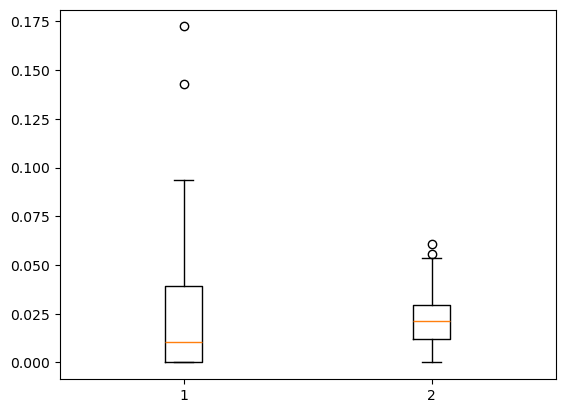

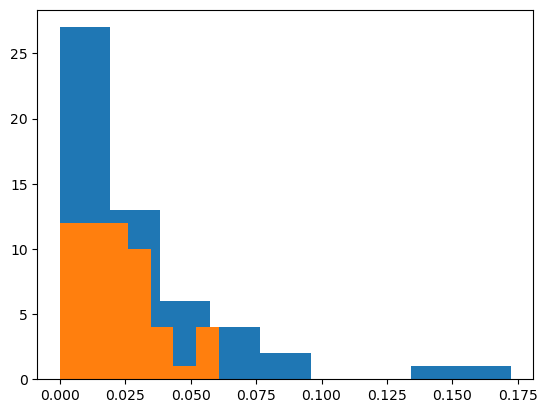

In [16]:
inter_scaled_connections_per_cell = []
intra_scaled_connections_per_cell = []

for pre_cell in coregistered_cell_indexes:
    # print(cell)
    pre_assembly_membership = mappings_a['assemblies_by_connectome_index'][pre_cell]
    pre_root_id = mappings_a['connectome_index_to_root_id'][pre_cell]

    # acceptable_post_assemblies = list(set(range(15)) - set(pre_assembly_membership))
    inter_outbound_connections_from_cell = 0
    inter_number_of_possible_posts_for_cell = 0
    intra_outbound_connections_from_cell = 0
    intra_number_of_possible_posts_for_cell = 0
    for post_cell in coregistered_post_cell_indexes:
        pre_cell_in_pre = pre_cell
        pre_root_id = mappings_a['connectome_index_to_root_id'][pre_cell_in_pre]
        pre_cell_in_post = mappings_a['pt_root_id_to_post_connectome_index'][pre_root_id]
        if pre_cell_in_post != post_cell:
            post_assembly_memberships = mappings_a['assemblies_by_post_connectome_index'][post_cell]
            if set(post_assembly_memberships).isdisjoint(pre_assembly_membership):
                inter_number_of_possible_posts_for_cell += 1
                if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                    inter_outbound_connections_from_cell += 1
            else:
                intra_number_of_possible_posts_for_cell += 1
                if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                    intra_outbound_connections_from_cell += 1
    if inter_number_of_possible_posts_for_cell > 0:
        inter_scaled_connections_per_cell.append(inter_outbound_connections_from_cell / inter_number_of_possible_posts_for_cell)
    if intra_number_of_possible_posts_for_cell > 0:
        intra_scaled_connections_per_cell.append(intra_outbound_connections_from_cell / intra_number_of_possible_posts_for_cell)

print("Ranksum")
print(stats.ranksums(intra_scaled_connections_per_cell, inter_scaled_connections_per_cell, alternative='greater'))
print(np.median(intra_scaled_connections_per_cell), np.median(inter_scaled_connections_per_cell))
print(np.median(inter_number_of_possible_posts_for_cell), np.median(inter_number_of_possible_posts_for_cell))
print(intra_scaled_connections_per_cell)
plt.figure()
plt.boxplot([intra_scaled_connections_per_cell, inter_scaled_connections_per_cell])
plt.figure()
plt.hist(intra_scaled_connections_per_cell, bins='auto')
plt.hist(inter_scaled_connections_per_cell, bins='auto')


## Intra-Assembly vs Inter-Assembly: Outbound

Intra-Assembly vs Inter-Assembly: Outbound
Pooled Intra-assembly Connections: 49 out of 1610 possible
Pooled Inter-assembly Connections: 326 out of 10466 possible


SUMMED PSDS

CONNECTION SUMMED PSD: Intra-A vs Inter-A
RanksumsResult(statistic=0.2636141369565949, pvalue=0.39603863202020984)

CONNECTION SUMMED PSD WITH ZEROS: Intra-A vs Inter-A
RanksumsResult(statistic=-0.0447420148322763, pvalue=0.517843527890306)

CONNECTION log10(SUMMED PSD): Intra-A vs Inter-A
RanksumsResult(statistic=0.2636141369565949, pvalue=0.39603863202020984)
TtestResult(statistic=0.14319139389265237, pvalue=0.44310817416114, df=373.0)

PRE-CELL COMBINED OUTBOUND SUMMED PSD: Intra-A vs Inter-A
RanksumsResult(statistic=2.573673250726645, pvalue=0.0050312626757965835)

PRE-CELL COMBINED OUTBOUND SUMMED PSD (NONZERO): Intra-A vs Inter-A
p={p_value}
RanksumsResult(statistic=-1.1561950917978219, pvalue=0.8761993165028519)


SYNAPSE COUNTS

CONNECTION SYNAPSE COUNT: Intra-A vs Inter-A
RanksumsResult(statistic=-0.39

Text(0.5, 1.0, 'PRE-CELL OUTBOUND CONNECTION PROB T-Test: Intra-A vs Intra-No-A\np=0.1694191705996151')

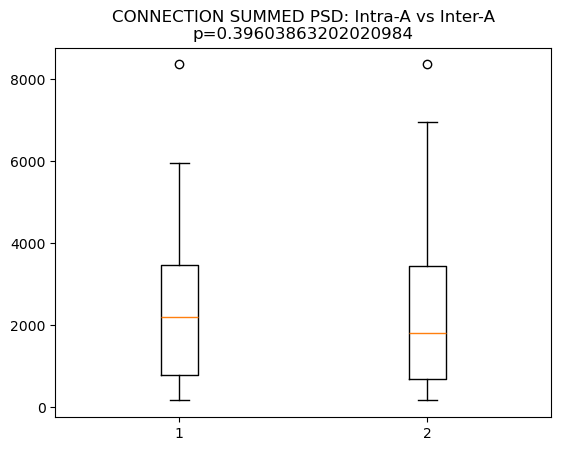

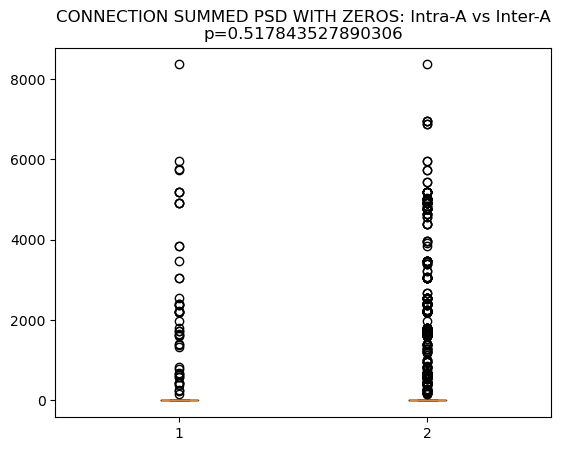

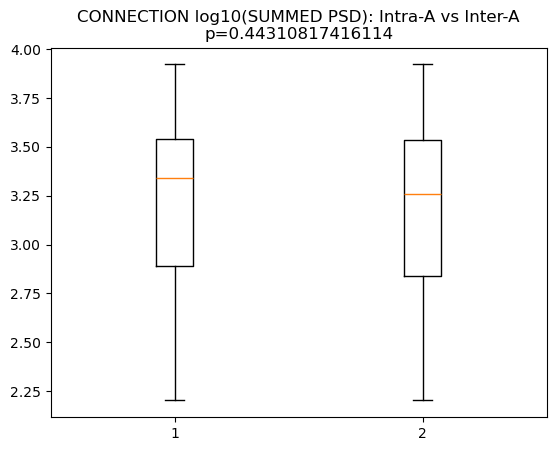

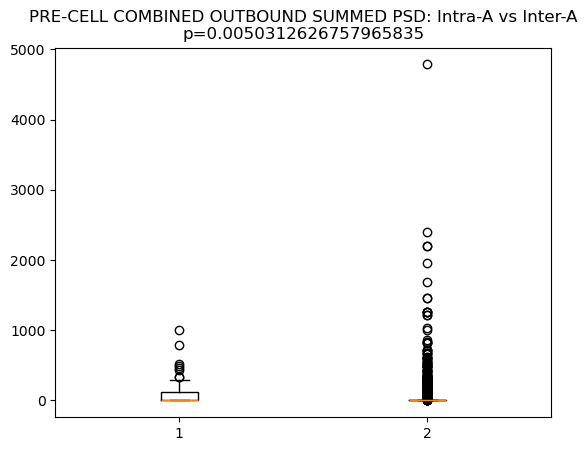

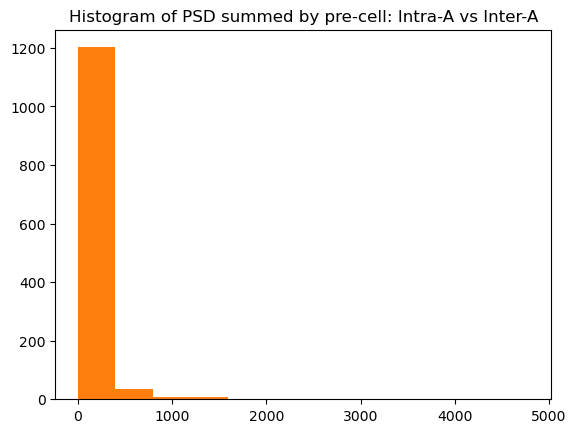

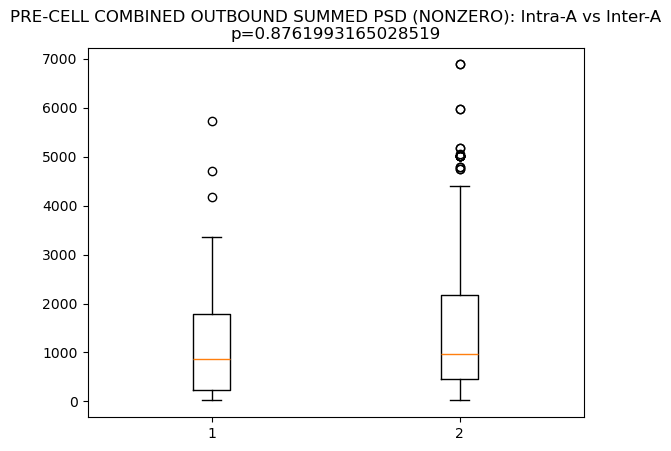

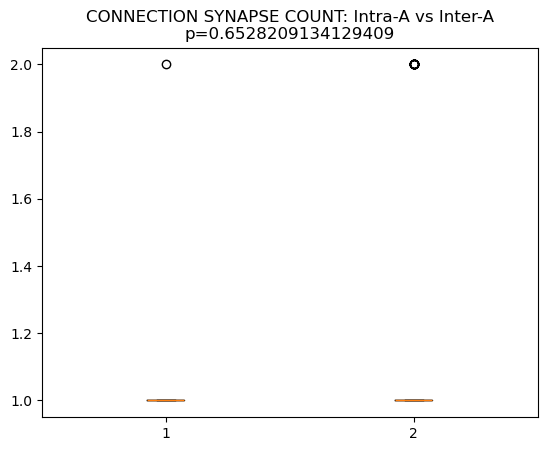

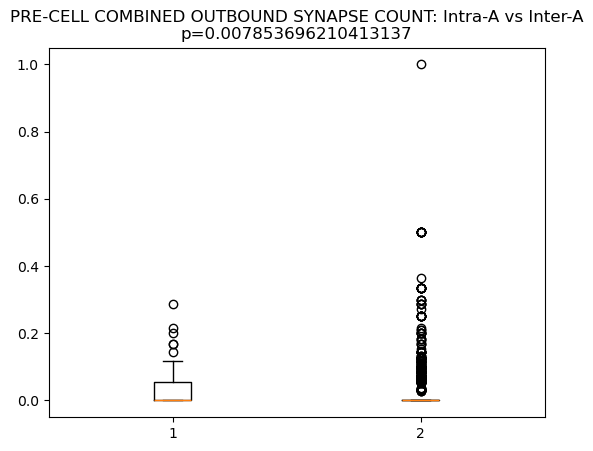

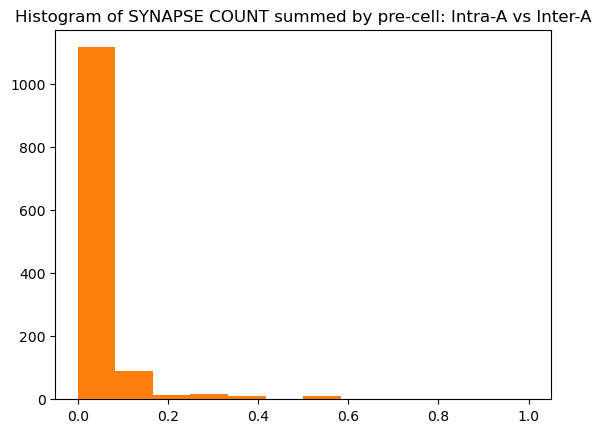

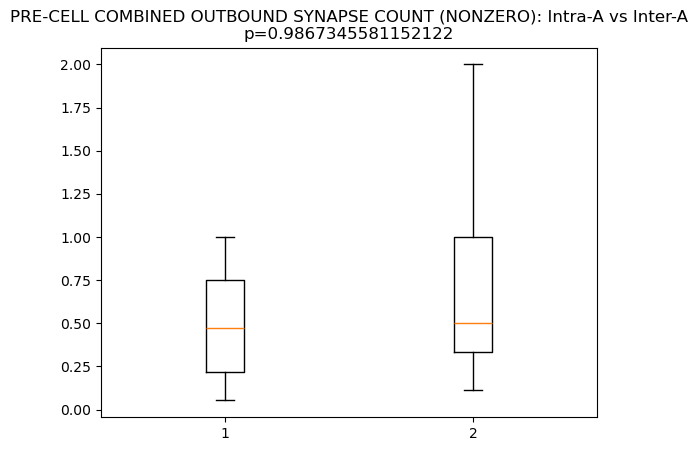

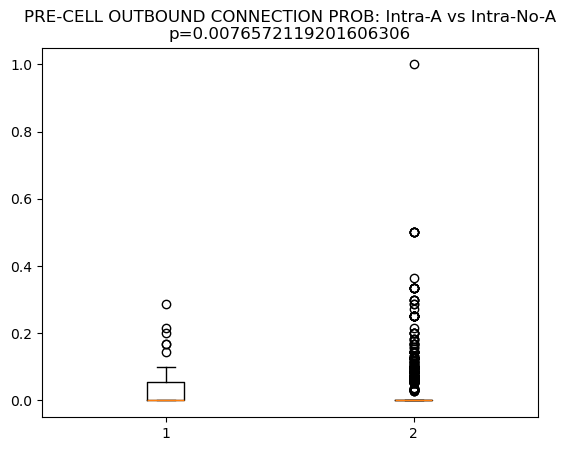

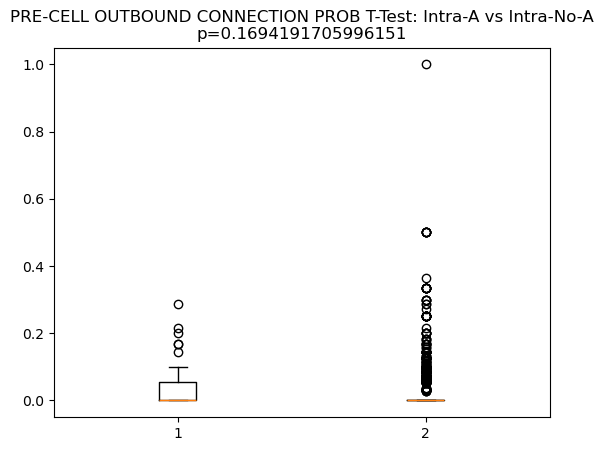

In [7]:
print('Intra-Assembly vs Inter-Assembly: Outbound')
zero_counts = 0
connections = 0
group_one_connection_summed_psd_sizes = []
group_one_connection_summed_psd_sizes_with_zeros = []
group_one_connection_synapse_count = []
summed_group_one_outbound_summed_psd_sizes = []
nonzero_summed_group_one_outbound_summed_psd_sizes = []
summed_group_one_outbound_synapse_counts = []
nonzero_summed_group_one_outbound_synapse_counts = []
summed_group_one_outbound_connection_probability = []
for ai in range(len(individual_assembly_indexes)):
    # This should be n_pre * n_post - 1 if connecting within group.
    # n_pre * n_unique_post if connecting to another group
    per_assembly_connections = 0
    possible_connections_within_group = len(individual_assembly_indexes[ai]) * (len(individual_post_assembly_indexes[ai]) - 1)
    possible_outbound_connections_within_group = (len(individual_post_assembly_indexes[ai]) - 1)
    for pre_cell in individual_assembly_indexes[ai]:
        summed_psd_sizes_sum = 0
        summed_synapse_counts = 0
        per_cell_connections = 0
        for post_cell in individual_post_assembly_indexes[ai]:
            if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                summed_psd_sizes = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                synapse_count = data_a['structural']['synapse_count_connectome'][pre_cell, post_cell]
                group_one_connection_summed_psd_sizes.append(summed_psd_sizes)
                group_one_connection_summed_psd_sizes_with_zeros.append(summed_psd_sizes)
                group_one_connection_synapse_count.append(synapse_count)
                summed_psd_sizes_sum += summed_psd_sizes
                summed_synapse_counts += synapse_count
                connections += 1
                per_assembly_connections += 1
                per_cell_connections += 1
            else:
                zero_counts += 1
                group_one_connection_summed_psd_sizes_with_zeros.append(0)
        if summed_psd_sizes_sum > 0:
            nonzero_summed_group_one_outbound_summed_psd_sizes.append(summed_psd_sizes_sum / per_assembly_connections)
        if summed_synapse_counts > 0:
            nonzero_summed_group_one_outbound_synapse_counts.append(summed_synapse_counts / per_assembly_connections)
        if possible_outbound_connections_within_group > 0:
            summed_group_one_outbound_summed_psd_sizes.append(summed_psd_sizes_sum / possible_outbound_connections_within_group)
            summed_group_one_outbound_synapse_counts.append(summed_synapse_counts / possible_outbound_connections_within_group)
            summed_group_one_outbound_connection_probability.append(per_cell_connections / possible_outbound_connections_within_group)
print(f'Pooled Intra-assembly Connections: {connections} out of {zero_counts + connections} possible')

zero_counts = 0
connections = 0

group_two_connection_summed_psd_sizes = []
group_two_connection_summed_psd_sizes_with_zeros = []
group_two_connection_synapse_count = []
summed_group_two_outbound_summed_psd_sizes = []
nonzero_summed_group_two_outbound_summed_psd_sizes = []
summed_group_two_outbound_synapse_counts = []
nonzero_summed_group_two_outbound_synapse_counts = []
summed_group_two_outbound_connection_probability = []

zero_counts = 0
connections = 0
summed_no_a_psd_sizes = []
summed_no_a_cell_outbound_sizes = []
nonzero_summed_no_a_cell_outbound_sizes = []
for pre_a in range(len(individual_assembly_indexes)):
    for post_a in range(len(individual_assembly_indexes)):
        per_assembly_connections = 0
        post_cells_in_pre_indexing = []
        for post_index in individual_post_assembly_indexes[post_a]:
            post_root = mappings_a['post_connectome_index_to_root_id'][post_index]
            try:
                post_cells_in_pre_indexing.append(mappings_a['pt_root_id_to_connectome_index'][post_root])
            except(KeyError):
                pass
        # print(post_cells_in_pre_indexing)
        overlap_to_remove_in_pre = list(set(individual_assembly_indexes[pre_a]) & set(post_cells_in_pre_indexing))
        overlap_root_ids_to_remove = [mappings_a['connectome_index_to_root_id'][c] for c in overlap_to_remove_in_pre]
        overlap_indexes_to_remove_in_post = [mappings_a['pt_root_id_to_post_connectome_index'][r] for r in overlap_root_ids_to_remove]
        unique_post_indexes_in_post = set(individual_post_assembly_indexes[post_a]) - set(overlap_indexes_to_remove_in_post)
        unique_post_indexes = unique_post_indexes_in_post
        possible_connections_inter_group = len(individual_assembly_indexes[pre_a]) * (len(unique_post_indexes))
        possible_outbound_connections_inter_group = len(unique_post_indexes)
        if pre_a != post_a:
            if len(unique_post_indexes) > 0:
                for pre_cell in individual_assembly_indexes[pre_a]:
                    # temp_sum = 0
                    summed_psd_sizes_sum = 0
                    summed_synapse_counts = 0
                    per_cell_connections = 0
                    for post_cell in unique_post_indexes:
                        # print(pre_cell, post_cell)
                        if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                            summed_psd_sizes = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                            synapse_count = data_a['structural']['synapse_count_connectome'][pre_cell, post_cell]
                            group_two_connection_summed_psd_sizes.append(summed_psd_sizes)
                            group_two_connection_summed_psd_sizes_with_zeros.append(summed_psd_sizes)
                            group_two_connection_synapse_count.append(synapse_count)
                            summed_psd_sizes_sum += summed_psd_sizes
                            summed_synapse_counts += synapse_count
                            connections += 1
                            per_cell_connections += 1
                            per_assembly_connections += 1
                        else:
                            zero_counts += 1
                            group_two_connection_summed_psd_sizes_with_zeros.append(0)
                    if summed_psd_sizes_sum > 0:
                        nonzero_summed_group_two_outbound_summed_psd_sizes.append(summed_psd_sizes_sum / per_assembly_connections)
                    if summed_synapse_counts > 0:
                        nonzero_summed_group_two_outbound_synapse_counts.append(summed_synapse_counts / per_assembly_connections)
                    summed_group_two_outbound_summed_psd_sizes.append(summed_psd_sizes_sum / possible_outbound_connections_inter_group)
                    summed_group_two_outbound_synapse_counts.append(summed_synapse_counts / possible_outbound_connections_inter_group)
                    summed_group_two_outbound_connection_probability.append(per_cell_connections / possible_outbound_connections_inter_group)
print(f'Pooled Inter-assembly Connections: {connections} out of {zero_counts + connections} possible')

print('\n\nSUMMED PSDS')

print('\nCONNECTION SUMMED PSD: Intra-A vs Inter-A')
p_value = stats.ranksums(group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes])
plt.title(f'CONNECTION SUMMED PSD: Intra-A vs Inter-A\np={p_value}')

print('\nCONNECTION SUMMED PSD WITH ZEROS: Intra-A vs Inter-A')
p_value = stats.ranksums(group_one_connection_summed_psd_sizes_with_zeros, group_two_connection_summed_psd_sizes_with_zeros, alternative='greater')[1]
print(stats.ranksums(group_one_connection_summed_psd_sizes_with_zeros, group_two_connection_summed_psd_sizes_with_zeros, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_summed_psd_sizes_with_zeros, group_two_connection_summed_psd_sizes_with_zeros])
plt.title(f'CONNECTION SUMMED PSD WITH ZEROS: Intra-A vs Inter-A\np={p_value}')

print('\nCONNECTION log10(SUMMED PSD): Intra-A vs Inter-A')
p_value = stats.ttest_ind(np.log10(group_one_connection_summed_psd_sizes), np.log10(group_two_connection_summed_psd_sizes), alternative='greater')[1]
print(stats.ranksums(np.log10(group_one_connection_summed_psd_sizes), np.log10(group_two_connection_summed_psd_sizes), alternative='greater'))
print(stats.ttest_ind(np.log10(group_one_connection_summed_psd_sizes), np.log10(group_two_connection_summed_psd_sizes), alternative='greater'))
plt.figure()
# stats.ttest_ind
plt.boxplot([np.log10(group_one_connection_summed_psd_sizes), np.log10(group_two_connection_summed_psd_sizes)])
plt.title(f'CONNECTION log10(SUMMED PSD): Intra-A vs Inter-A\np={p_value}')

print('\nPRE-CELL COMBINED OUTBOUND SUMMED PSD: Intra-A vs Inter-A')
p_value = stats.ranksums(summed_group_one_outbound_summed_psd_sizes, summed_group_two_outbound_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(summed_group_one_outbound_summed_psd_sizes, summed_group_two_outbound_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_outbound_summed_psd_sizes, summed_group_two_outbound_summed_psd_sizes])
plt.title(f'PRE-CELL COMBINED OUTBOUND SUMMED PSD: Intra-A vs Inter-A\np={p_value}')
# print("Medians", np.median(summed_group_one_outbound_summed_psd_sizes), np.median(summed_group_two_outbound_summed_psd_sizes))

plt.figure()
plt.hist(summed_group_one_outbound_summed_psd_sizes, bins='auto')
plt.hist(summed_group_two_outbound_summed_psd_sizes, bins='auto')
plt.title('Histogram of PSD summed by pre-cell: Intra-A vs Inter-A')

print('\nPRE-CELL COMBINED OUTBOUND SUMMED PSD (NONZERO): Intra-A vs Inter-A\np={p_value}')
p_value = stats.ranksums(nonzero_summed_group_one_outbound_summed_psd_sizes, nonzero_summed_group_two_outbound_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(nonzero_summed_group_one_outbound_summed_psd_sizes, nonzero_summed_group_two_outbound_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_group_one_outbound_summed_psd_sizes, nonzero_summed_group_two_outbound_summed_psd_sizes])
plt.title(f'PRE-CELL COMBINED OUTBOUND SUMMED PSD (NONZERO): Intra-A vs Inter-A\np={p_value}')


print('\n\nSYNAPSE COUNTS')
print('\nCONNECTION SYNAPSE COUNT: Intra-A vs Inter-A')
p_value = stats.ranksums(group_one_connection_synapse_count, group_two_connection_synapse_count, alternative='greater')[1]
print(stats.ranksums(group_one_connection_synapse_count, group_two_connection_synapse_count, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_synapse_count, group_two_connection_synapse_count])
plt.title(f'CONNECTION SYNAPSE COUNT: Intra-A vs Inter-A\np={p_value}')

print('\nPRE-CELL COMBINED OUTBOUND SYNAPSE COUNT: Intra-A vs Inter-A')
p_value = stats.ranksums(summed_group_one_outbound_synapse_counts, summed_group_two_outbound_synapse_counts, alternative='greater')[1]
print(stats.ranksums(summed_group_one_outbound_synapse_counts, summed_group_two_outbound_synapse_counts, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_outbound_synapse_counts, summed_group_two_outbound_synapse_counts])
plt.title(f'PRE-CELL COMBINED OUTBOUND SYNAPSE COUNT: Intra-A vs Inter-A\np={p_value}')
# print("Medians", np.median(summed_group_one_outbound_synapse_counts), np.median(summed_group_two_outbound_synapse_counts))

plt.figure()
plt.hist(summed_group_one_outbound_synapse_counts, bins='auto')
plt.hist(summed_group_two_outbound_synapse_counts, bins='auto')
plt.title('Histogram of SYNAPSE COUNT summed by pre-cell: Intra-A vs Inter-A')

print('\nPRE-CELL COMBINED OUTBOUND SYNAPSE COUNT (NONZERO): Intra-A vs Inter-A')
p_value = stats.ranksums(nonzero_summed_group_one_outbound_synapse_counts, nonzero_summed_group_two_outbound_synapse_counts, alternative='greater')[1]
print(stats.ranksums(nonzero_summed_group_one_outbound_synapse_counts, nonzero_summed_group_two_outbound_synapse_counts, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_group_one_outbound_synapse_counts, nonzero_summed_group_two_outbound_synapse_counts])
plt.title(f'PRE-CELL COMBINED OUTBOUND SYNAPSE COUNT (NONZERO): Intra-A vs Inter-A\np={p_value}')

print('\n\nPRE-CELL OUTBOUND CONNECTION PROB: Intra-A vs Intra-No-A')
p_value = stats.ranksums(summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability, alternative='greater')[1]
print(stats.ranksums(summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability])
plt.title(f'PRE-CELL OUTBOUND CONNECTION PROB: Intra-A vs Intra-No-A\np={p_value}')

print('\n\nPRE-CELL OUTBOUND CONNECTION PROB T-Test: Intra-A vs Intra-No-A')
p_value = stats.ttest_ind(summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability, alternative='greater')[1]
print(stats.ttest_ind(summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_outbound_connection_probability, summed_group_two_outbound_connection_probability])
plt.title(f'PRE-CELL OUTBOUND CONNECTION PROB T-Test: Intra-A vs Intra-No-A\np={p_value}')




## Intra-Assembly vs Inter-Assembly: Inbound

Intra-Assembly vs Inter-Assembly: Inbound
Pooled Intra-assembly Connections: 49 out of 1610 possible
Pooled Inter-assembly Connections: 274 out of 9365 possible


SUMMED PSDS

CONNECTION SUMMED PSD: Intra-A vs Inter-A
RanksumsResult(statistic=0.21176538944745799, pvalue=0.4161450356708311)


PRE-CELL COMBINED inbound SUMMED PSD: Intra-A vs Inter-A
RanksumsResult(statistic=2.7273801994525857, pvalue=0.003191971726671707)

PRE-CELL COMBINED inbound SUMMED PSD (NONZERO): Intra-A vs Inter-A
RanksumsResult(statistic=-1.9065317343755155, pvalue=0.971709373771433)


SYNAPSE COUNTS

CONNECTION SYNAPSE COUNT: Intra-A vs Inter-A
RanksumsResult(statistic=-0.4642229517691334, pvalue=0.6787559905463776)

PRE-CELL COMBINED inbound SYNAPSE COUNT: Intra-A vs Inter-A
RanksumsResult(statistic=2.60435896069049, pvalue=0.004602314825632546)

PRE-CELL COMBINED inbound SYNAPSE COUNT (NONZERO): Intra-A vs Inter-A
RanksumsResult(statistic=-3.2693111024407235, pvalue=0.9994609515253078)


PRE-CELL OUTBOUND CON

Text(0.5, 1.0, 'PRE-CELL OUTBOUND CONNECTION PROB: Intra-A vs Intra-No-A\np=0.004348444428889654')

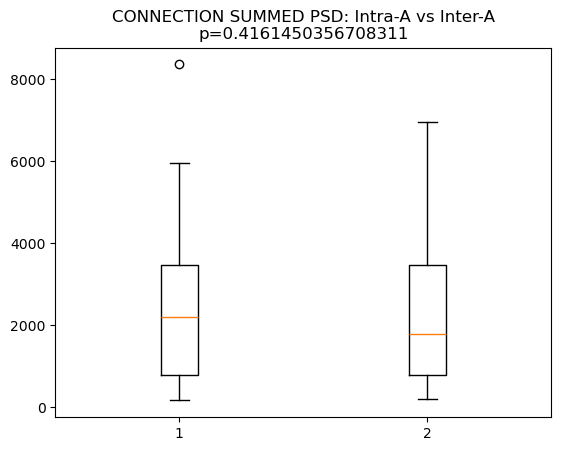

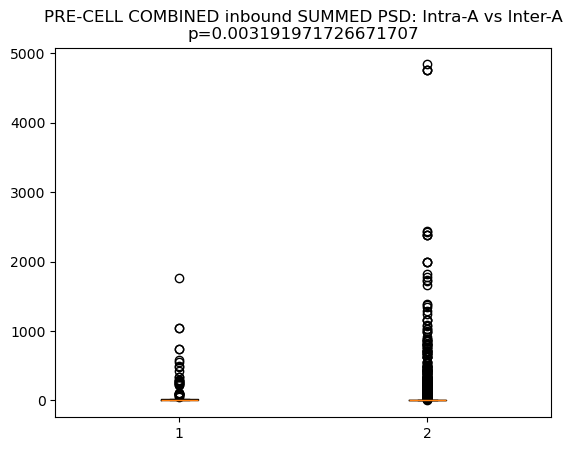

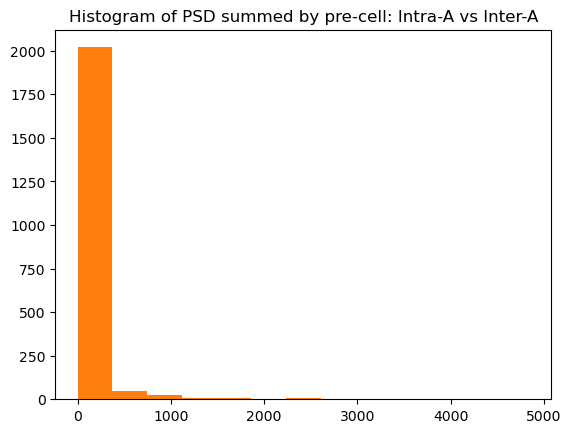

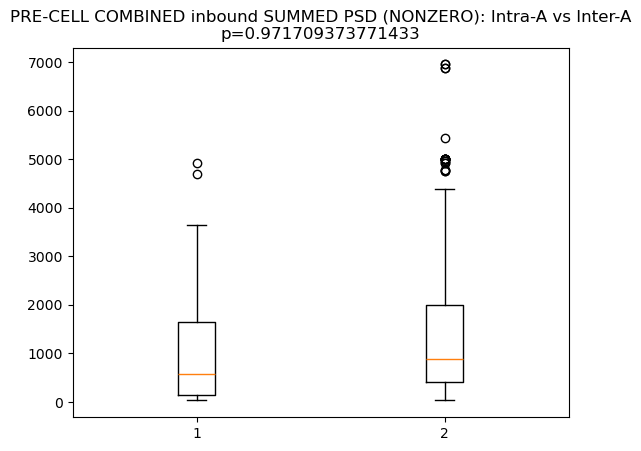

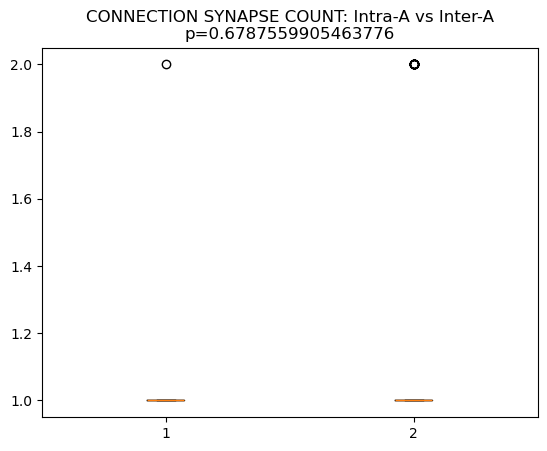

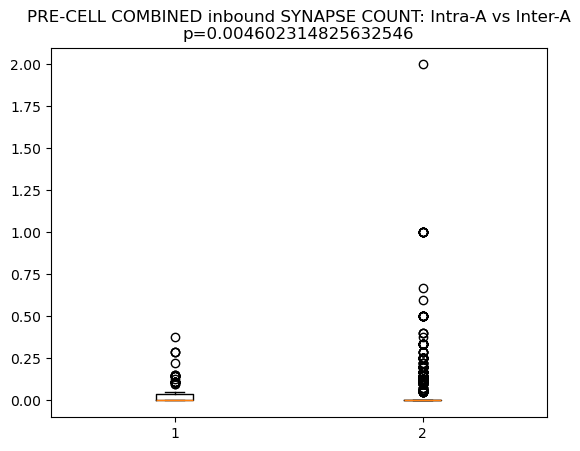

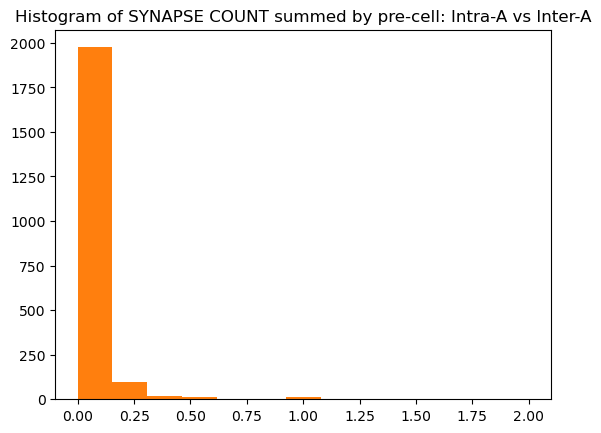

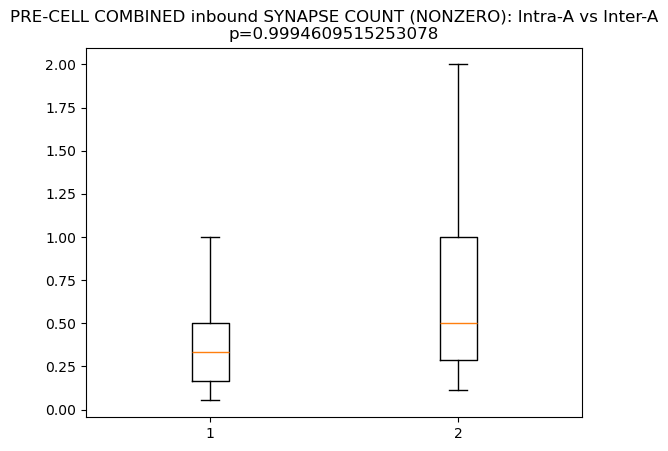

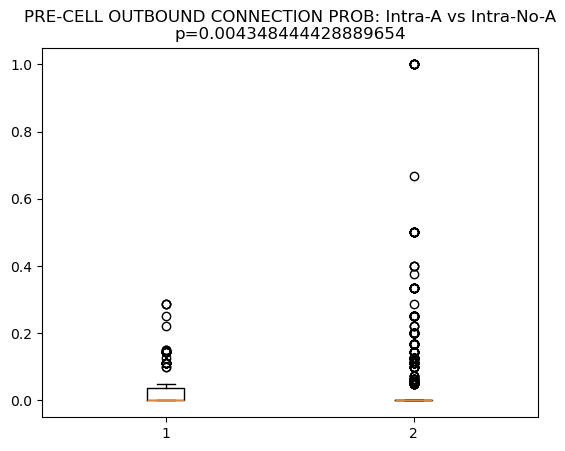

In [8]:
print('Intra-Assembly vs Inter-Assembly: Inbound')
zero_counts = 0
connections = 0
group_one_connection_summed_psd_sizes = []
group_one_connection_synapse_count = []
summed_group_one_inbound_summed_psd_sizes = []
nonzero_summed_group_one_inbound_summed_psd_sizes = []
summed_group_one_inbound_synapse_counts = []
nonzero_summed_group_one_inbound_synapse_counts = []
summed_group_one_inbound_connection_probability = []
for ai in range(len(individual_assembly_indexes)):
    # This should be n_pre * n_post - 1 if connecting within group.
    # n_pre * n_unique_post if connecting to another group
    per_assembly_connections = 0
    possible_connections_within_group = len(individual_assembly_indexes[ai]) * (len(individual_post_assembly_indexes[ai]) - 1)
    possible_inbound_connections_within_group = (len(individual_assembly_indexes[ai]) - 1)
    for post_cell in individual_post_assembly_indexes[ai]:
        summed_psd_sizes_sum = 0
        summed_synapse_counts = 0
        per_cell_connections = 0
        for pre_cell in individual_assembly_indexes[ai]:
            if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                summed_psd_sizes = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                synapse_count = data_a['structural']['synapse_count_connectome'][pre_cell, post_cell]
                group_one_connection_summed_psd_sizes.append(summed_psd_sizes)
                group_one_connection_synapse_count.append(synapse_count)
                summed_psd_sizes_sum += summed_psd_sizes
                summed_synapse_counts += synapse_count
                connections += 1
                per_assembly_connections += 1
                per_cell_connections += 1
            else:
                zero_counts += 1
        if summed_psd_sizes_sum > 0:
            nonzero_summed_group_one_inbound_summed_psd_sizes.append(summed_psd_sizes_sum / per_assembly_connections)
        if summed_synapse_counts > 0:
            nonzero_summed_group_one_inbound_synapse_counts.append(summed_synapse_counts / per_assembly_connections)
        if possible_inbound_connections_within_group > 0:
            summed_group_one_inbound_summed_psd_sizes.append(summed_psd_sizes_sum / possible_inbound_connections_within_group)
            summed_group_one_inbound_synapse_counts.append(summed_synapse_counts / possible_inbound_connections_within_group)
            summed_group_one_inbound_connection_probability.append(per_cell_connections / possible_inbound_connections_within_group)
print(f'Pooled Intra-assembly Connections: {connections} out of {zero_counts + connections} possible')


zero_counts = 0
connections = 0

group_two_connection_summed_psd_sizes = []
group_two_connection_synapse_count = []
summed_group_two_inbound_summed_psd_sizes = []
nonzero_summed_group_two_inbound_summed_psd_sizes = []
summed_group_two_inbound_synapse_counts = []
nonzero_summed_group_two_inbound_synapse_counts = []
summed_group_two_inbound_connection_probability = []

zero_counts = 0
connections = 0
summed_no_a_psd_sizes = []
summed_no_a_cell_inbound_sizes = []
nonzero_summed_no_a_cell_inbound_sizes = []
for pre_a in range(len(individual_assembly_indexes)):
    for post_a in range(len(individual_assembly_indexes)):
        # unique_post_indexes = list(set(individual_post_assembly_indexes[post_a]) - set(individual_assembly_indexes[pre_a]))
        post_cells_in_pre_indexing = []
        for post_index in individual_post_assembly_indexes[post_a]:
            post_root = mappings_a['post_connectome_index_to_root_id'][post_index]
            try:
                post_cells_in_pre_indexing.append(mappings_a['pt_root_id_to_connectome_index'][post_root])
            except(KeyError):
                pass
        # print(post_cells_in_pre_indexing)
        overlap_to_remove_in_pre = list(set(individual_assembly_indexes[pre_a]) & set(post_cells_in_pre_indexing))
        overlap_root_ids_to_remove = [mappings_a['connectome_index_to_root_id'][c] for c in overlap_to_remove_in_pre]
        overlap_indexes_to_remove = [mappings_a['pt_root_id_to_connectome_index'][r] for r in overlap_root_ids_to_remove]
        # overlap_indexes_to_remove_in_post = [mappings_a['pt_root_id_to_post_connectome_index'][r] for r in overlap_root_ids_to_remove]
        # unique_post_indexes_in_post = set(individual_post_assembly_indexes[post_a]) - set(overlap_indexes_to_remove_in_post)
        unique_post_indexes = individual_post_assembly_indexes[post_a]
        unique_pre_indexes = list(set(individual_assembly_indexes[pre_a]) - set(overlap_indexes_to_remove))
        per_assembly_connections = 0
        possible_connections_within_group = len(unique_post_indexes) * (unique_pre_indexes)
        possible_inbound_connections_within_group = len(unique_pre_indexes)
        if pre_a != post_a:
            if possible_inbound_connections_within_group > 0:
                for post_cell in unique_post_indexes:
                    # temp_sum = 0
                    summed_psd_sizes_sum = 0
                    summed_synapse_counts = 0
                    per_cell_connections = 0
                    for pre_cell in unique_pre_indexes:
                        # print(pre_cell, post_cell)
                        if len(two_chain_results_array[np.where(np.logical_and(two_chain_results_array[:,0] == pre_cell, two_chain_results_array[:,-1] == post_cell))]) > 0:
                            summed_psd_sizes = data_a['structural']['summed_size_connectome'][pre_cell, post_cell] 
                            synapse_count = data_a['structural']['synapse_count_connectome'][pre_cell, post_cell]
                            group_two_connection_summed_psd_sizes.append(summed_psd_sizes)
                            group_two_connection_synapse_count.append(synapse_count)
                            summed_psd_sizes_sum += summed_psd_sizes
                            summed_synapse_counts += synapse_count
                            connections += 1
                            per_assembly_connections += 1
                            per_cell_connections += 1
                        else:
                            zero_counts += 1
                    if summed_psd_sizes_sum > 0:
                        nonzero_summed_group_two_inbound_summed_psd_sizes.append(summed_psd_sizes_sum / per_assembly_connections)
                    if summed_synapse_counts > 0:
                        nonzero_summed_group_two_inbound_synapse_counts.append(summed_synapse_counts / per_assembly_connections)
                    summed_group_two_inbound_summed_psd_sizes.append(summed_psd_sizes_sum / possible_inbound_connections_within_group)
                    summed_group_two_inbound_synapse_counts.append(summed_synapse_counts / possible_inbound_connections_within_group)
                    summed_group_two_inbound_connection_probability.append(per_cell_connections / possible_inbound_connections_within_group)
print(f'Pooled Inter-assembly Connections: {connections} out of {zero_counts + connections} possible')

print('\n\nSUMMED PSDS')

print('\nCONNECTION SUMMED PSD: Intra-A vs Inter-A')
p_value = stats.ranksums(group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_summed_psd_sizes, group_two_connection_summed_psd_sizes])
plt.title(f'CONNECTION SUMMED PSD: Intra-A vs Inter-A\np={p_value}')

print('\n\nPRE-CELL COMBINED inbound SUMMED PSD: Intra-A vs Inter-A')
p_value = stats.ranksums(summed_group_one_inbound_summed_psd_sizes, summed_group_two_inbound_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(summed_group_one_inbound_summed_psd_sizes, summed_group_two_inbound_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_inbound_summed_psd_sizes, summed_group_two_inbound_summed_psd_sizes])
plt.title(f'PRE-CELL COMBINED inbound SUMMED PSD: Intra-A vs Inter-A\np={p_value}')
# print("Medians", np.median(summed_group_one_inbound_summed_psd_sizes), np.median(summed_group_two_inbound_summed_psd_sizes))

plt.figure()
plt.hist(summed_group_one_inbound_summed_psd_sizes, bins='auto')
plt.hist(summed_group_two_inbound_summed_psd_sizes, bins='auto')
plt.title('Histogram of PSD summed by pre-cell: Intra-A vs Inter-A')

print('\nPRE-CELL COMBINED inbound SUMMED PSD (NONZERO): Intra-A vs Inter-A')
p_value = stats.ranksums(nonzero_summed_group_one_inbound_summed_psd_sizes, nonzero_summed_group_two_inbound_summed_psd_sizes, alternative='greater')[1]
print(stats.ranksums(nonzero_summed_group_one_inbound_summed_psd_sizes, nonzero_summed_group_two_inbound_summed_psd_sizes, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_group_one_inbound_summed_psd_sizes, nonzero_summed_group_two_inbound_summed_psd_sizes])
plt.title(f'PRE-CELL COMBINED inbound SUMMED PSD (NONZERO): Intra-A vs Inter-A\np={p_value}')

print('\n\nSYNAPSE COUNTS')
print('\nCONNECTION SYNAPSE COUNT: Intra-A vs Inter-A')
p_value = stats.ranksums(group_one_connection_synapse_count, group_two_connection_synapse_count, alternative='greater')[1]
print(stats.ranksums(group_one_connection_synapse_count, group_two_connection_synapse_count, alternative='greater'))
plt.figure()
plt.boxplot([group_one_connection_synapse_count, group_two_connection_synapse_count])
plt.title(f'CONNECTION SYNAPSE COUNT: Intra-A vs Inter-A\np={p_value}')

print('\nPRE-CELL COMBINED inbound SYNAPSE COUNT: Intra-A vs Inter-A')
p_value = stats.ranksums(summed_group_one_inbound_synapse_counts, summed_group_two_inbound_synapse_counts, alternative='greater')[1]
print(stats.ranksums(summed_group_one_inbound_synapse_counts, summed_group_two_inbound_synapse_counts, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_inbound_synapse_counts, summed_group_two_inbound_synapse_counts])
plt.title(f'PRE-CELL COMBINED inbound SYNAPSE COUNT: Intra-A vs Inter-A\np={p_value}')
# print("Medians", np.median(summed_group_one_inbound_synapse_counts), np.median(summed_group_two_inbound_synapse_counts))

plt.figure()
plt.hist(summed_group_one_inbound_synapse_counts, bins='auto')
plt.hist(summed_group_two_inbound_synapse_counts, bins='auto')
plt.title('Histogram of SYNAPSE COUNT summed by pre-cell: Intra-A vs Inter-A')

print('\nPRE-CELL COMBINED inbound SYNAPSE COUNT (NONZERO): Intra-A vs Inter-A')
p_value = stats.ranksums(nonzero_summed_group_one_inbound_synapse_counts, nonzero_summed_group_two_inbound_synapse_counts, alternative='greater')[1]
print(stats.ranksums(nonzero_summed_group_one_inbound_synapse_counts, nonzero_summed_group_two_inbound_synapse_counts, alternative='greater'))
plt.figure()
plt.boxplot([nonzero_summed_group_one_inbound_synapse_counts, nonzero_summed_group_two_inbound_synapse_counts])
plt.title(f'PRE-CELL COMBINED inbound SYNAPSE COUNT (NONZERO): Intra-A vs Inter-A\np={p_value}')

print('\n\nPRE-CELL OUTBOUND CONNECTION PROB: Intra-A vs Intra-No-A')
p_value = stats.ranksums(summed_group_one_inbound_connection_probability, summed_group_two_inbound_connection_probability, alternative='greater')[1]
print(stats.ranksums(summed_group_one_inbound_connection_probability, summed_group_two_inbound_connection_probability, alternative='greater'))
plt.figure()
plt.boxplot([summed_group_one_inbound_connection_probability, summed_group_two_inbound_connection_probability])
plt.title(f'PRE-CELL OUTBOUND CONNECTION PROB: Intra-A vs Intra-No-A\np={p_value}')
